# Discretizations
Here we show how different discretizations work within MasterMSM. An important note is that not all discretizations will be sensible for all systems, but as usual the alanine dipeptide is a good testbed.

We start by importing a number of libraries for plotting and analysis that will be useful for our work.

In [1]:
%load_ext autoreload
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

Next we import the ```traj``` module and read the molecular simulation trajectory in the ```xtc``` compressed format from Gromacs.

In [2]:
from mastermsm.trajectory import traj
tr = traj.TimeSeries(top='data/alaTB.gro', traj=['data/protein_only.xtc'])
print (tr.mdt)

<mdtraj.Trajectory with 10003 frames, 19 atoms, 3 residues, and unitcells>


### Core Ramachandran angle regions
Following previous work we can use core regions in the Ramachandran map to define our states. We use utilities from the [MDtraj](http://mdtraj.org) package to compute the Phi and Psi dihedrals.

In [3]:
import mdtraj as md
phi = md.compute_phi(tr.mdt)
psi = md.compute_psi(tr.mdt)
res = [x for x in tr.mdt.topology.residues]

Then we run the actual discretization, using only two states for the alpha and extended conformations.

In [3]:
tr.discretize(states=['A', 'E'])
tr.find_keys()

Finally we derive the MSM using the tools from the ```msm``` module. In particular, we use the ```SuperMSM``` class that will help build MSMs at various lag times.

In [5]:
from mastermsm.msm import msm
msm_alaTB = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB.do_msm(i)
    msm_alaTB.msms[i].do_trans()
    msm_alaTB.msms[i].boots()


 Building MSM from 
 [['data/protein_only.xtc']]
     # states: 2


Next we gather results from all these MSMs and plot the relaxation time corresponding to the ```A```$\leftrightarrow$```E``` transition.

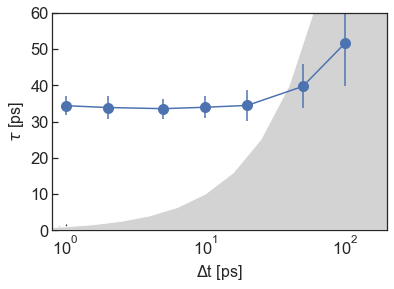

In [7]:
tau_vs_lagt = np.array([[x,msm_alaTB.msms[x].tauT[0],msm_alaTB.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB.msms.keys())])

fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau$ [ps]', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(0,60)
_ = ax.set_xscale('log')
#ax.set_yscale('log')

### Fine grid on the Ramachandran map
Alternatively we can make a grid on the Ramachandran map with many more states.

In [8]:
tr.discretize(method="ramagrid", nbins=20)
tr.find_keys()

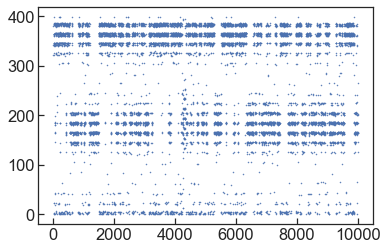

In [9]:
fig, ax = plt.subplots()
ax.plot([x for x in tr.distraj], '.', ms=1)

Then we repeat the same steps as before, but with this fine grained MSM.

In [10]:
from mastermsm.msm import msm
msm_alaTB_grid = msm.SuperMSM([tr])
for i in [1, 2, 5, 10, 20, 50, 100]:
    msm_alaTB_grid.do_msm(i)
    msm_alaTB_grid.msms[i].do_trans()
    msm_alaTB_grid.msms[i].boots()


 Building MSM from 
 [['data/protein_only.xtc']]
     # states: 197


First we take a look at the dependence of the slowest relaxation time with the lag time, $\Delta t$ for the construction of the Markov model as a minimal quality control.

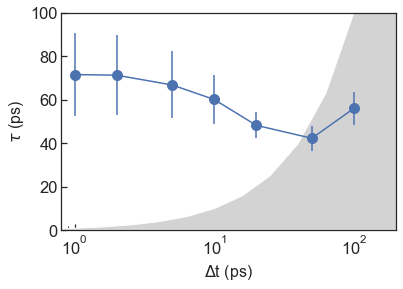

In [15]:
tau_vs_lagt = np.array([[x,msm_alaTB_grid.msms[x].tauT[0],msm_alaTB_grid.msms[x].tau_std[0]] \
               for x in sorted(msm_alaTB_grid.msms.keys())])
fig, ax = plt.subplots()
ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t (ps)', fontsize=16)
ax.set_ylabel(r'$\tau$ (ps)', fontsize=16)
ax.set_xlim(0.8,200)
ax.set_ylim(0,100)
_ = ax.set_xscale('log')

As a surprise we find that in the fine-grained MSM the slowest relaxation time is slower than in the one where we consider only the $\alpha$-helical and extended basins. We can look at the whole spectrum of eigenvalues to understand why.

Text(0, 0.5, '$\\tau_i$ (ns)')

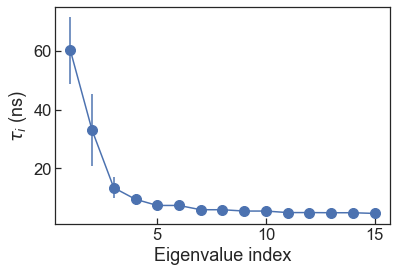

In [17]:
fig, ax = plt.subplots()
ax.errorbar(range(1,16),msm_alaTB_grid.msms[10].tauT[0:15], fmt='o-', \
            yerr= msm_alaTB_grid.msms[10].tau_std[0:15], ms=10)
ax.set_xlabel('Eigenvalue index')
ax.set_ylabel(r'$\tau_i$ (ns)')
#ax.set_yscale('log')

So there is an eigenvalue (the second slowest, $\lambda_2$) whose corresponding relaxation time ($\tau_2$) approximately matches that of the coarse-grained MSM.
We can understand which dynamical processes the eigenvectors are associated to by looking at the corresponding eigenvectors. For this we recalculate the transition matrix but now recovering the eigenvectors. 

In [18]:
msm_alaTB_grid.msms[10].do_trans(evecs=True)

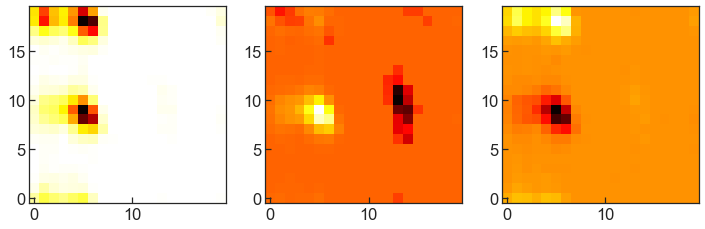

In [20]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,0])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = i[1]
ax[0].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='hot')
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,1])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = -i[1]
ax[1].imshow(mat.transpose(), interpolation="none", origin='lower', \
             cmap='hot')
mat = np.zeros((20,20), float)
for i in [x for x in zip(msm_alaTB_grid.msms[10].keep_keys, \
                         msm_alaTB_grid.msms[10].rvecsT[:,2])]:
    #print i, i[0]%20, int(i[0]/20), -i[1]
    mat[i[0]%20, int(i[0]/20)] = -i[1]
_ = ax[2].imshow(mat.transpose(), interpolation="none", origin='lower', \
                 cmap='hot')

Here we are plotting the values of the eigenvectors so that the state indexes correspond to the position in the Ramachandran map. On the left, we show the stationary eigenvector, which is directly proportional to the equilibrium population. The center plot corresponds to the slowest dynamical mode, which in fact corresponds to the $\alpha_L$ and the $\alpha_R$ transition. Finally, on the right, we find that the eigenvector corresponding to the timescale $\tau_2$ in fact corresponds to the exchange between the ```A``` and ```E``` regions. This explains the mapping between the timescales in the coarse and fine grained MSMs.